# Study of potential bias in the rental process
### Tyfenn Eloy, Mathias Berthonneau, Arthur-Louis Bonneau, Loris Nezan

In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log_low = pm4py.read_xes('data/renting_log_low.xes')
log_medium = pm4py.read_xes('data/renting_log_medium.xes')
log_high = pm4py.read_xes('data/renting_log_high.xes')

c:\Users\Tyf\Documents\Fac\M2\Fouille de proc\projet_process_mining\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:07<00:00, 1332.80it/s]
c:\Users\Tyf\Documents\Fac\M2\Fouille de proc\projet_process_mining\venv\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
c:\Users\Tyf\Documents\Fac\M2\Fouille de proc\projet_process_mining\venv\Lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`.

In [3]:
log_low.columns

Index(['activity', 'resource', 'time', 'concept:name', 'time:timestamp',
       '@@index', 'case:concept:name', 'case:german speaking',
       'case:yearsOfEducation', 'case:age', 'case:gender', 'case:citizen',
       'case:protected', 'case:married', 'case:@@case_index', 'case:case'],
      dtype='object')

## General trace analysis

In [4]:
CASE_ID_COL = 'concept:name'
ACTIVITY_COL = 'activity'
TIMESTAMP_COL = 'time:timestamp'

print(f"Case ID Column: {CASE_ID_COL}")
print(f"Activity Column: {ACTIVITY_COL}")
print(f"Timestamp Column: {TIMESTAMP_COL}")

Case ID Column: concept:name
Activity Column: activity
Timestamp Column: time:timestamp


Statistics for the `low` dataset:

In [5]:
num_cases = len(log_low.groupby(CASE_ID_COL))
num_events = len(log_low)

variants = pm4py.get_variants(log_low)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 96440
Number of variants: 508


Statistics for the `medium` dataset:

In [6]:
num_cases = len(log_medium.groupby(CASE_ID_COL))
num_events = len(log_medium)

variants = pm4py.get_variants(log_medium)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 105555
Number of variants: 610


Statistics for the `high` dataset:

In [7]:
num_cases = len(log_high.groupby(CASE_ID_COL))
num_events = len(log_high)

variants = pm4py.get_variants(log_high)
num_variants = len(variants)

print(f"Number of cases: {num_cases}")
print(f"Number of events: {num_events}")
print(f"Number of variants: {num_variants}")

Number of cases: 16
Number of events: 89972
Number of variants: 496


The general statistics of the different datasets are similar in term of size. We will be able to compare them easily.

## Drawing a general diagram of the flow

In [8]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

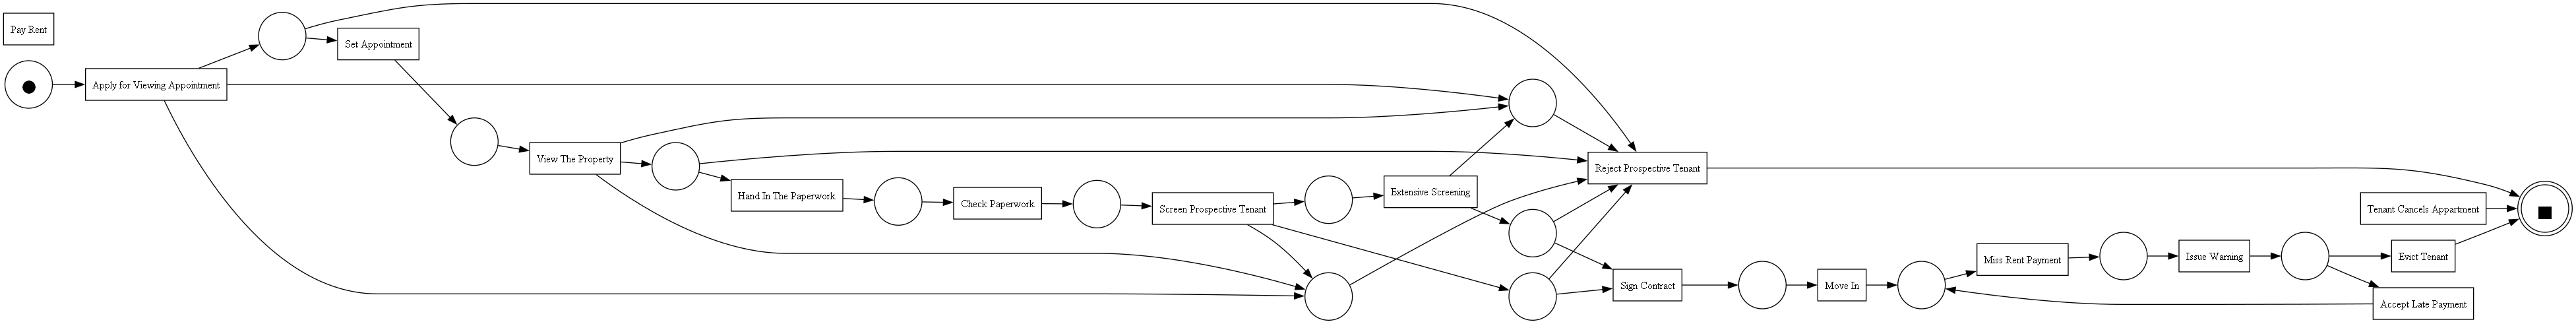

In [9]:
net, initial_marking, final_marking = alpha_miner.apply(log_low)

pm4py.view_petri_net(net, initial_marking, final_marking)

In the renting process, we can identify 4 main steps:

- The user is applying for a place
- The landlord is accepting or rejecting the application
- The user is paying the rent or not
- The user can get evicted or not

Based on this, we can look for potential bias in the process regarding the additional information we have on the users :

- Age
- Education
- Gender
- Citizenship
- Life situation (marriage, single)

In [10]:

def printSexism(log, logName):
    
    # split per "case:age"
    log_male = log[log['case:gender'] ==  True]
    log_female = log[log['case:gender'] == False]
    nb_trace_male = len(log_male)
    nb_trace_female = len(log_female)

    # Get len events "Sign Contract" 
    signed_contract_male = len(log_male[log_male['activity'] == 'Sign Contract'])
    signed_contract_female = len(log_female[log_female['activity'] == 'Sign Contract'])

    # Get len events "Reject Prospective Tenant"
    rejected_contract_male = len(log_male[log_male['activity'] == 'Reject Prospective Tenant'])
    rejected_contract_female = len(log_female[log_female['activity'] == 'Reject Prospective Tenant'])

    # get % of rejected contract
    pc_reject_male = nb_trace_male/rejected_contract_male
    pc_reject_female = nb_trace_female/rejected_contract_female

    # get % of accepted contract
    pc_signed_male = nb_trace_male/signed_contract_male
    pc_signed_female = nb_trace_female/signed_contract_female

    #Print the results
    print("-"*30)
    print("Event log: " + logName)
    print("Nombre traces hommes: {}, nombre de signatures: {}, nombre de refus: {}".format(nb_trace_male, signed_contract_male, rejected_contract_male))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_male, pc_signed_male))
    print("Nombre traces femme: {}, nombre de signatures: {}, nombre de refus: {}".format(nb_trace_female, signed_contract_female, rejected_contract_female))
    print("-- % refus: {}, % acceptation: {}".format(pc_reject_female, pc_signed_female))
print("-"*30)

------------------------------


In [11]:
printSexism(log_low, "low")
printSexism(log_medium, "medium")
printSexism(log_high, "high")

------------------------------
Event log: low
Nombre traces hommes: 54204, nombre de signatures: 1970, nombre de refus: 3557
-- % refus: 15.238684284509418, % acceptation: 27.51472081218274
Nombre traces femme: 42236, nombre de signatures: 1440, nombre de refus: 3033
-- % refus: 13.925486317177711, % acceptation: 29.330555555555556
------------------------------
Event log: medium
Nombre traces hommes: 51694, nombre de signatures: 2032, nombre de refus: 2861
-- % refus: 18.068507514854947, % acceptation: 25.43996062992126
Nombre traces femme: 53861, nombre de signatures: 2131, nombre de refus: 2976
-- % refus: 18.098454301075268, % acceptation: 25.274988268418582
------------------------------
Event log: high
Nombre traces hommes: 55329, nombre de signatures: 1823, nombre de refus: 3966
-- % refus: 13.950832072617247, % acceptation: 30.350521119034557
Nombre traces femme: 34643, nombre de signatures: 947, nombre de refus: 3264
-- % refus: 10.613664215686274, % acceptation: 36.5818373812